**Note:** I'm making an assumption here that conversion rate is the rate of conversion of a visit on the product page to a sale.
i.e. for a given product: (sales)/(visits on PDP)

### Standard Lib Imports

In [1]:
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parent)

In [2]:
from src import config
from src.helper import *

### Load Data

In [3]:
sales = read_data('sales.csv')
purchases = read_data('purchase.csv')
availability = read_data('availability.csv')
product_details = read_data('product details.csv')
visits = read_data('visits on pdp.csv')
prices = read_data('prices.csv')

In [4]:
# Convert date columns to datetime type

sales['date'] = pd.to_datetime(sales['date'])
purchases['date'] = pd.to_datetime(purchases['date'])
availability['date'] = pd.to_datetime(availability['date'])
visits['date'] = pd.to_datetime(visits['date'])

In [5]:
sales = sales.sort_values(by=['product_id', 'date'])
purchases = purchases.sort_values(by=['product_id', 'date'])
visits = visits.sort_values(by=['product_id', 'date'])
availability = availability.sort_values(by=['product_id', 'date'])

In [6]:
# Get a quantity of sales, visits for every day

sales = sales.set_index('date').groupby('product_id')['quantity'].resample('D').sum().reset_index()
visits = visits.set_index('date').groupby('product_id')['visits'].resample('D').sum().reset_index()

In [7]:
sales.head()

,product_id,date,quantity
0,61380,2020-01-27,1
1,61380,2020-01-28,0
2,61380,2020-01-29,0
3,61380,2020-01-30,0
4,61380,2020-01-31,0


In [8]:
visits.head()

,product_id,date,visits
0,61380,2020-01-01,1
1,61380,2020-01-02,5
2,61380,2020-01-03,2
3,61380,2020-01-04,7
4,61380,2020-01-05,5


In [9]:
visits_sales = visits.merge(sales, on=['product_id', 'date'], how='left').fillna(0)

In [10]:
visits_sales = visits_sales.rename({'quantity': 'sales'}, axis=1)
visits_sales['sales'] = visits_sales['sales'].astype(int)

In [11]:
visits_sales.head()

,product_id,date,visits,sales
0,61380,2020-01-01,1,0
1,61380,2020-01-02,5,0
2,61380,2020-01-03,2,0
3,61380,2020-01-04,7,0
4,61380,2020-01-05,5,0


In [12]:
# Correlation between sales and visits

round(np.corrcoef(visits_sales['sales'], visits_sales['visits'])[0, 1], 2)

0.48

Calculate conversion as (sales/visits)

In [13]:
visits_sales['conversion'] = (visits_sales['sales']/visits_sales['visits']).fillna(0)

In [14]:
# Total number of products 

visits_sales['product_id'].nunique()

8510

Let's see how the average daily conversion looks across all the products

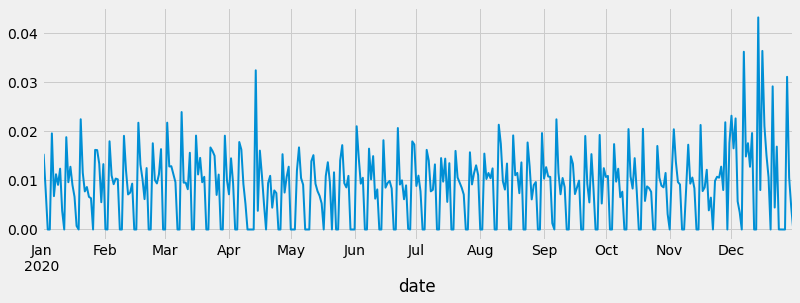

In [15]:
daily_conversion = (visits_sales.groupby('date')['sales'].sum()/visits_sales.groupby('date')['visits'].sum())
daily_conversion.plot(linewidth=config.lw, figsize=config.FIGSIZE);

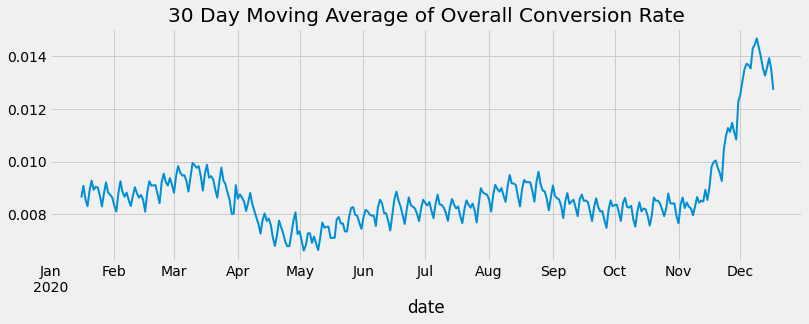

In [16]:
daily_conversion.rolling(30, center=True)\
    .mean().plot(linewidth=config.lw)
plt.title('30 Day Moving Average of Overall Conversion Rate');

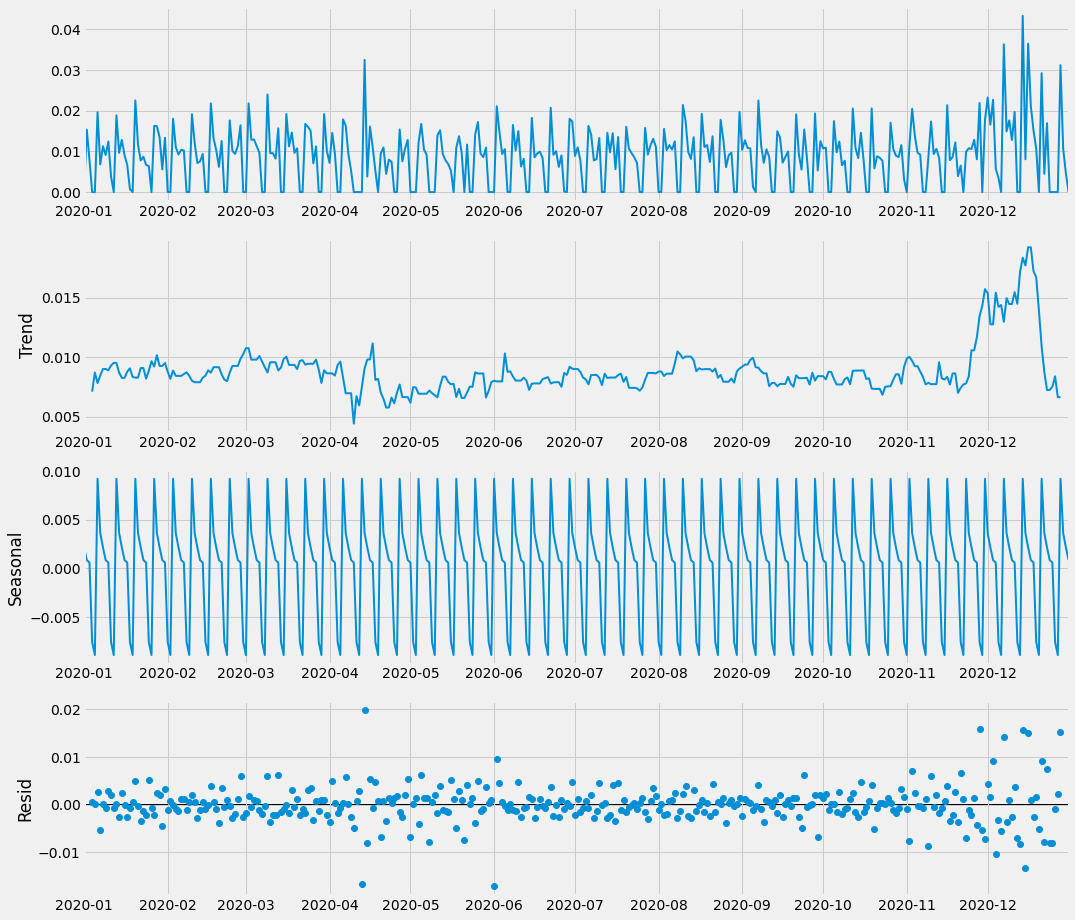

In [17]:
plot_decomposed(daily_conversion)

- The weekly trend in our data is clearly noticeable. 

We'll first try to model this overall daily conversion.

In [18]:
y = daily_conversion.copy()

In [19]:
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    drop=True,
)
X = dp.in_sample()

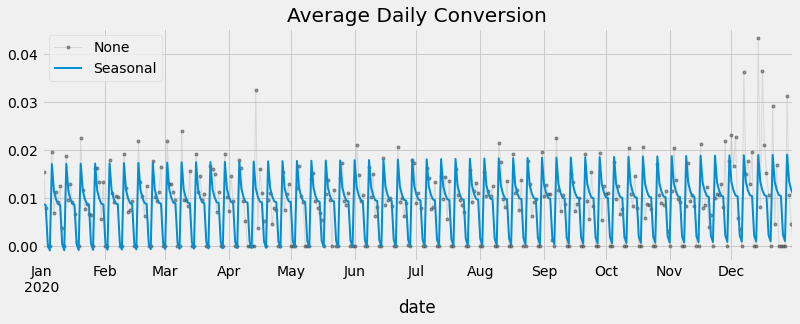

In [20]:
model = LinearRegression().fit(X, y)

y_pred = pd.Series(
    model.predict(X),
    index=X.index,
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, linewidth=1, alpha=0.5, title="Average Daily Conversion")
ax = y_pred.plot(linewidth=2, ax=ax, label="Seasonal")
ax.legend();

We can see that a simple model utilising the trend and seasonality is able to do a fairly decent job at predicting the conversion rate. 

In [21]:
date_range = pd.date_range(start='2021-01-01', end='2021-01-07')

In [22]:
X_test = dp.out_of_sample(7, forecast_index=date_range)

In [23]:
y_pred_oos = model.predict(X_test)

**Predictions for the first 7 days of 2021**

In [24]:
pd.Series(y_pred_oos, index=date_range)

2021-01-01    0.010476
2021-01-02    0.002335
2021-01-03    0.001015
2021-01-04    0.019051
2021-01-05    0.013457
2021-01-06    0.011725
2021-01-07    0.010674
Freq: D, dtype: float64

**Conversion Rates by product**

The approach we'll be taking will be to build a *boosted hybrid*. A simple linear regression model will be used to model the trend of the data. Then we'll be training an XGBoost on the residuals of the first model. 

Source - https://www.kaggle.com/learn/time-series

In [25]:
visits_sales_conv = visits_sales[['product_id', 'date', 'conversion']].set_index(['product_id', 'date'])

In [26]:
y = visits_sales_conv.unstack(['product_id']).fillna(0)
y = y.replace(np.inf, 1)

In [27]:
y_original = y.copy()

In [28]:
y.head(3)

conversion                                                    \
product_id  61380     383408    383439    385237    385485    385888      
date                                                                      
2020-01-01        0.0  0.000000       0.0       0.0       0.0       0.0   
2020-01-02        0.0  0.076923       0.0       0.0       0.0       1.0   
2020-01-03        0.0  0.000000       0.0       0.0       0.0       0.0   

                                                    ...                      \
product_id 386415    386446    408611    409045     ... 353462155 353462186   
date                                                ...                       
2020-01-01       0.0       0.0       0.0       0.0  ...       0.0       0.0   
2020-01-02       0.0       0.0       0.0       0.0  ...       0.0       0.0   
2020-01-03       0.0       0.0       0.0       0.0  ...       0.0       0.0   

                                                                        \
product_id 353462217 353462248 353462310 353462341 353462651 353462682   
date                                                                     
2020-01-01       0.0       0.0       0.0       0.0       0.0       0.0   
2020-01-02       0.0       0.0       0.0       0.0       0.0       0.0   
2020-01-03       0.0       0.0       0.0       0.0       0.0       0.0   

                                
product_id 353594897 353595083  
date                            
2020-01-01       0.0       0.0  
2020-01-02       0.0       0.0  
2020-01-03       0.0       0.0  

[3 rows x 8510 columns]

In [29]:
# Create training data
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=2,
#     seasonal=True,
    drop=True,
)

X = dp.in_sample()

In [30]:
X_train = X.loc['2020-01-01': '2020-12-23']
y_train = y.loc['2020-01-01': '2020-12-23']

X_test = X.loc['2020-12-24': '2020-12-31']
y_test = y.loc['2020-12-24': '2020-12-31']

In [31]:
# Let's take a look at the LR data

X_train.head(3)

,const,trend,trend_squared
date,,,
2020-01-01,1.0,1.0,1.0
2020-01-02,1.0,2.0,4.0
2020-01-03,1.0,3.0,9.0


In [32]:
y_train.head(3)

conversion                                                    \
product_id  61380     383408    383439    385237    385485    385888      
date                                                                      
2020-01-01        0.0  0.000000       0.0       0.0       0.0       0.0   
2020-01-02        0.0  0.076923       0.0       0.0       0.0       1.0   
2020-01-03        0.0  0.000000       0.0       0.0       0.0       0.0   

                                                    ...                      \
product_id 386415    386446    408611    409045     ... 353462155 353462186   
date                                                ...                       
2020-01-01       0.0       0.0       0.0       0.0  ...       0.0       0.0   
2020-01-02       0.0       0.0       0.0       0.0  ...       0.0       0.0   
2020-01-03       0.0       0.0       0.0       0.0  ...       0.0       0.0   

                                                                        \
product_id 353462217 353462248 353462310 353462341 353462651 353462682   
date                                                                     
2020-01-01       0.0       0.0       0.0       0.0       0.0       0.0   
2020-01-02       0.0       0.0       0.0       0.0       0.0       0.0   
2020-01-03       0.0       0.0       0.0       0.0       0.0       0.0   

                                
product_id 353594897 353595083  
date                            
2020-01-01       0.0       0.0  
2020-01-02       0.0       0.0  
2020-01-03       0.0       0.0  

[3 rows x 8510 columns]

In [33]:
# Model for obtaining trend

model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [34]:
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

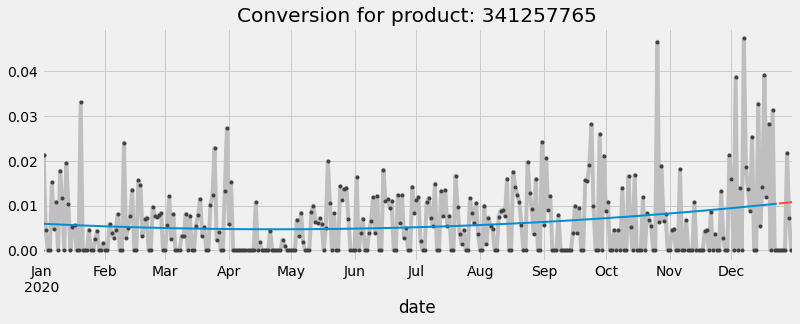

In [35]:
PRODUCT_ID = 341257765 

ax = y.loc(axis=1)['conversion', PRODUCT_ID].plot(**plot_params)
ax = y_fit.loc(axis=1)['conversion', PRODUCT_ID].plot(ax=ax, linewidth=config.lw)
ax = y_pred.loc(axis=1)['conversion', PRODUCT_ID].plot(ax=ax, linewidth=config.lw)
ax.set_title(f'Conversion for product: {PRODUCT_ID}');

We'll now create X, y data for the XGBoost model

In [36]:
X = y.stack()
y = X.pop('conversion')

In [37]:
X = X.reset_index('product_id')
X['product_id'], _ = X['product_id'].factorize()
X['month'] = X.index.month
X['day_of_week'] = X.index.dayofweek

In [38]:
X_train, X_test = X.loc['2020-01-01': '2020-12-23'], X.loc['2020-12-24': '2020-12-31']
y_train, y_test = y.loc['2020-01-01': '2020-12-23'], y.loc['2020-12-24': '2020-12-31']

In [39]:
y_fit = y_fit.stack().squeeze()
y_pred = y_pred.stack().squeeze()

In [40]:
y_resid = y_train - y_fit

In [41]:
# Train XGBoost on the residuals

xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [42]:
# Add the predicted residuals onto the predicted trends

y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

In [43]:
# Bring y into previous form in order to plot

y = y.reset_index().set_index(['date', 'product_id']).unstack('product_id')
y_fit_boosted = y_fit_boosted.reset_index().set_index(['date', 'product_id']).unstack('product_id')
y_pred_boosted = y_pred_boosted.reset_index().set_index(['date', 'product_id']).unstack('product_id')

Let's look at the forecasts for two example products

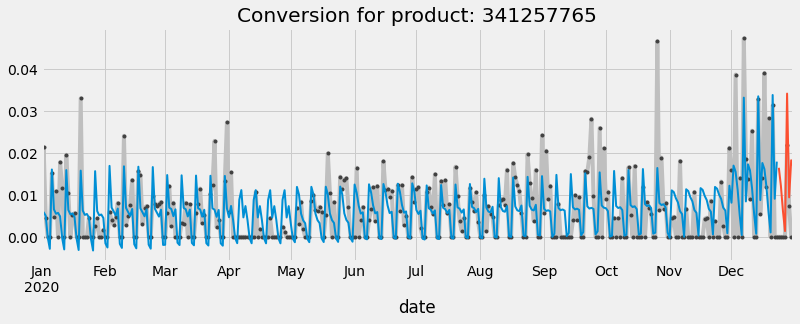

In [44]:
PRODUCT_ID = 341257765

ax = y.loc(axis=1)['conversion', PRODUCT_ID].plot(**plot_params)
ax = y_fit_boosted.loc(axis=1)['conversion', PRODUCT_ID].plot(ax=ax, linewidth=config.lw)
ax = y_pred_boosted.loc(axis=1)['conversion', PRODUCT_ID].plot(ax=ax, linewidth=config.lw)
ax.set_title(f'Conversion for product: {PRODUCT_ID}');

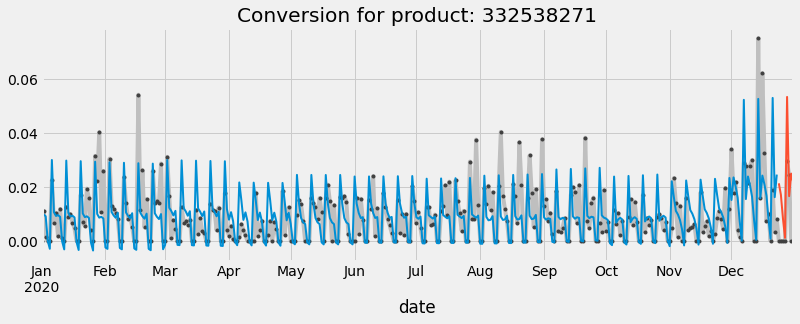

In [45]:
PRODUCT_ID = 332538271

ax = y.loc(axis=1)['conversion', PRODUCT_ID].plot(**plot_params)
ax = y_fit_boosted.loc(axis=1)['conversion', PRODUCT_ID].plot(ax=ax, linewidth=config.lw)
ax = y_pred_boosted.loc(axis=1)['conversion', PRODUCT_ID].plot(ax=ax, linewidth=config.lw)
ax.set_title(f'Conversion for product: {PRODUCT_ID}');

**Forecasting for the first 7 days of 2021**

In [46]:
# We need to first create the test data for our models

# Create test trend data
dp = DeterministicProcess(
    index=date_range,
    constant=True,
    order=2,
    drop=True,
)

X_oos = dp.in_sample()

In [47]:
y_trend_oos = pd.DataFrame(model.predict(X_oos),
                           index=date_range, 
                           columns=y_original.columns
                          )

In [48]:
X_oos_xgb = y_trend_oos.stack()

In [49]:
# we'll store the trend predictions separately 

y_trend_oos = X_oos_xgb.pop('conversion')

In [50]:
X_oos_xgb = X_oos_xgb.reset_index('product_id')
X_oos_xgb['product_id'], _ = X_oos_xgb['product_id'].factorize()
X_oos_xgb['month'] = X_oos_xgb.index.month
X_oos_xgb['day_of_week'] = X_oos_xgb.index.dayofweek

In [51]:
y_final_pred = xgb.predict(X_oos_xgb) + y_trend_oos

**Final Forecast for first 7 days of 2021**

In [52]:
y_final_pred.unstack().clip(0)

product_id,61380,383408,383439,385237,385485,385888,386415,386446,408611,409045,...,353462155,353462186,353462217,353462248,353462310,353462341,353462651,353462682,353594897,353595083
2021-01-01,0.000000,0.058756,0.000000,0.044356,0.000000,0.048827,0.000000,0.023021,0.000000,0.025479,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-02,0.000000,0.047292,0.000000,0.050345,0.000000,0.054946,0.000000,0.024393,0.000000,0.024114,...,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544,0.000544
2021-01-03,0.000000,0.029156,0.000000,0.040361,0.000000,0.045091,0.000000,0.014379,0.000000,0.017739,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-04,0.042231,0.118293,0.012120,0.056579,0.001893,0.010271,0.000000,0.018954,0.000000,0.018674,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,0.009493,0.082094,0.009772,0.241089,0.008874,0.110054,0.000000,0.030689,0.000000,0.045720,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-06,0.009525,0.079400,0.007831,0.084283,0.010324,0.145861,0.030596,0.063333,0.030596,0.078661,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-07,0.019912,0.089040,0.018220,0.098658,0.025461,0.113359,0.025329,0.057440,0.025329,0.062803,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
